# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [42]:
#@title Imports and Global Variables (make sure to run this cell)  { display-mode: "form" }
from __future__ import absolute_import, division, print_function

#@markdown This sets the warning status (default is `ignore`, since this notebook runs correctly)
warning_status = "ignore" #@param ["ignore", "always", "module", "once", "default", "error"]
import warnings
warnings.filterwarnings(warning_status)
with warnings.catch_warnings():
    warnings.filterwarnings(warning_status, category=DeprecationWarning)
    warnings.filterwarnings(warning_status, category=UserWarning)

import numpy as np
import os
#@markdown This sets the styles of the plotting (default is styled like plots from [FiveThirtyeight.com](https://fivethirtyeight.com/))
matplotlib_style = 'fivethirtyeight' #@param ['fivethirtyeight', 'bmh', 'ggplot', 'seaborn', 'default', 'Solarize_Light2', 'classic', 'dark_background', 'seaborn-colorblind', 'seaborn-notebook']
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
import matplotlib.axes as axes;
from matplotlib.patches import Ellipse
%matplotlib inline
import seaborn as sns; sns.set_context('notebook')
from IPython.core.pylabtools import figsize
#@markdown This sets the resolution of the plot outputs (`retina` is the highest resolution)
notebook_screen_res = 'retina' #@param ['retina', 'png', 'jpeg', 'svg', 'pdf']
%config InlineBackend.figure_format = notebook_screen_res

import tensorflow as tf
tfe = tf.contrib.eager

# Eager Execution
#@markdown Check the box below if you want to use [Eager Execution](https://www.tensorflow.org/guide/eager)
#@markdown Eager execution provides An intuitive interface, Easier debugging, and a control flow comparable to Numpy. You can read more about it on the [Google AI Blog](https://ai.googleblog.com/2017/10/eager-execution-imperative-define-by.html)
use_tf_eager = False #@param {type:"boolean"}

# Use try/except so we can easily re-execute the whole notebook.
if use_tf_eager:
    try:
        tf.enable_eager_execution()
    except:
        pass

import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

  
def evaluate(tensors):
    """Evaluates Tensor or EagerTensor to Numpy `ndarray`s.
    Args:
    tensors: Object of `Tensor` or EagerTensor`s; can be `list`, `tuple`,
      `namedtuple` or combinations thereof.
 
    Returns:
      ndarrays: Object with same structure as `tensors` except with `Tensor` or
        `EagerTensor`s replaced by Numpy `ndarray`s.
    """
    if tf.executing_eagerly():
        return tf.contrib.framework.nest.pack_sequence_as(
            tensors,
            [t.numpy() if tf.contrib.framework.is_tensor(t) else t
             for t in tf.contrib.framework.nest.flatten(tensors)])
    return sess.run(tensors)

class _TFColor(object):
    """Enum of colors used in TF docs."""
    red = '#F15854'
    blue = '#5DA5DA'
    orange = '#FAA43A'
    green = '#60BD68'
    pink = '#F17CB0'
    brown = '#B2912F'
    purple = '#B276B2'
    yellow = '#DECF3F'
    gray = '#4D4D4D'
    def __getitem__(self, i):
        return [
            self.red,
            self.orange,
            self.green,
            self.blue,
            self.pink,
            self.brown,
            self.purple,
            self.yellow,
            self.gray,
        ][i % 9]
TFColor = _TFColor()

def session_options(enable_gpu_ram_resizing=True, enable_xla=False):
    """
    Allowing the notebook to make use of GPUs if they're available.
    
    XLA (Accelerated Linear Algebra) is a domain-specific compiler for linear 
    algebra that optimizes TensorFlow computations.
    """
    config = tf.ConfigProto()
    config.log_device_placement = True
    if enable_gpu_ram_resizing:
        # `allow_growth=True` makes it possible to connect multiple colabs to your
        # GPU. Otherwise the colab malloc's all GPU ram.
        config.gpu_options.allow_growth = True
    if enable_xla:
        # Enable on XLA. https://www.tensorflow.org/performance/xla/.
        config.graph_options.optimizer_options.global_jit_level = (
            tf.OptimizerOptions.ON_1)
    return config


def reset_sess(config=None):
    """
    Convenience function to create the TF graph & session or reset them.
    """
    if config is None:
        config = session_options(enable_gpu_ram_resizing=True, enable_xla=False)
    global sess
    tf.reset_default_graph()
    try:
        sess.close()
    except:
        pass
    sess = tf.InteractiveSession(config=config)

reset_sess()


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



## Import and format the data

In [2]:
transcript['value'].value_counts()

{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}                  14983
{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}                  14924
{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}                  14891
{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}                  14835
{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}                  14374
{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}                  14305
{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}                  11848
{'offer id': '3f207df678b143eea3cee63160fa8bed'}                  11761
{'offer id': '2906b810c7d4411798c6938adc9daaa5'}                  11750
{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}                  10331
{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4', 'reward': 2}      5317
{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2', 'reward': 3}      5156
{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9', 'reward': 5}      4354
{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d', 'reward': 5}   

In [3]:
## 'values' column looks like it has inconsistent keys: explore the data keys here

all_index_keys = transcript['value'].unique
all_index_keys

<bound method Series.unique of 0          {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1          {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2          {'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3          {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4          {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
5          {'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
6          {'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
7          {'offer id': '3f207df678b143eea3cee63160fa8bed'}
8          {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
9          {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
10         {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
11         {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
12         {'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}
13         {'offer id': '3f207df678b143eea3cee63160fa8bed'}
14         {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
15         {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
16       

In [4]:
def get_offer_id(entry):
    if 'offer_id' in entry:
        return entry['offer_id']
    elif 'offer id' in entry:
        return entry['offer id']
    else:
        return -1
    
def get_amount(entry):
    if 'amount' in entry:
        return entry['amount']
    else:
        return -1
    
def get_reward(entry):
    if 'reward' in entry:
        return entry['reward']
    else:
        return -1
    

In [5]:
transcript['offer_id'] = transcript['value'].apply(get_offer_id)
transcript['amount'] = transcript['value'].apply(get_amount)
transcript['reward'] = transcript['value'].apply(get_reward)

In [6]:
transcript[['value','offer_id', 'reward', 'amount']]

,value,offer_id,reward,amount
0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,-1,-1.00
1,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,-1,-1.00
2,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,-1,-1.00
3,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,-1,-1.00
4,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0,-1,-1.00
5,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},f19421c1d4aa40978ebb69ca19b0e20d,-1,-1.00
6,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},2298d6c36e964ae4a3e7e9706d1fb8c2,-1,-1.00
7,{'offer id': '3f207df678b143eea3cee63160fa8bed'},3f207df678b143eea3cee63160fa8bed,-1,-1.00
8,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,-1,-1.00
9,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,-1,-1.00


## Explore the Data

In [7]:
# Examine the offer ids
portfolio.head(20)

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [8]:
transcript.head(20)
transcript['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [9]:
profile.head(20)

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0
9,118,20161122,None,8974fc5686fe429db53ddde067b88302,NaN


In [10]:
#TODO:
#parse dates
#determine how long a member
#impute age 118
#impute income
#cluster
profile.gender.unique()

array([None, 'F', 'M', 'O'], dtype=object)

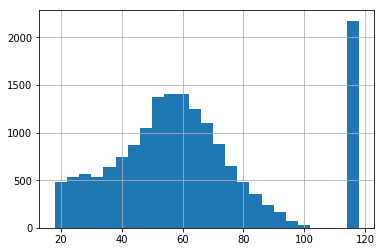

In [11]:
profile.age.hist(bins = 25)

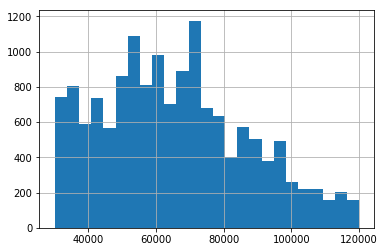

In [12]:
profile.income.hist(bins = 25)

In [13]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import math
import sklearn.preprocessing as pp
from sklearn.decomposition import PCA


from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from IPython import display

# magic word for producing visualizations in notebook
%matplotlib inline

In [14]:
## Discussion of variable types
##TODO

In [15]:
mean_age = int(profile[profile['age'] != 118]['age'].sum() / profile[profile['age'] != 118].shape[0])
mean_age

54

In [16]:
mean_income = profile[profile['income'].isnull() == False]['income'].sum() / profile[profile['income'].isnull() == False].shape[0]
mean_income

65404.9915682968

In [17]:
def impute_age(age):
    if age == 118:
        return mean_age
    else:
        return age
    
def impute_income(income):
    if income != income: #since np.NaN != np.NaN
        return mean_income
    else:
        return income
    
profile['age'] = profile['age'].apply(lambda x: impute_age(x))
profile['income'] = profile['income'].apply(lambda x: impute_income(x))

In [18]:
import datetime
from dateutil.parser import parse

def parse_date(date_string):
    """
    parses a date from a string, and catches string formatting exceptions (returns empty string)
    """
    try:
        event_date = datetime.datetime.strptime(str(date_string).strip(), "%Y%m%d").date()
    except:
        event_date = ""
    return event_date

In [19]:
profile['date_parsed'] = profile['became_member_on'].apply(parse_date)
today = datetime.datetime.strptime('20190301', "%Y%m%d").date()
profile['member_for'] = today - profile['date_parsed']
profile['member_for'] = profile['member_for'].apply(lambda x: int(x.days/7))

In [20]:
def encode_gender(gend):
    if gend is None:
        return 'No_response'
    else:
        return gend

profile['gender'] = profile['gender'].apply(encode_gender)

profile.head(20)

,age,became_member_on,gender,id,income,date_parsed,member_for
0,54,20170212,No_response,68be06ca386d4c31939f3a4f0e3dd783,65404.991568,2017-02-12,106
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.000000,2017-07-15,84
2,54,20180712,No_response,38fe809add3b4fcf9315a9694bb96ff5,65404.991568,2018-07-12,33
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.000000,2017-05-09,94
4,54,20170804,No_response,a03223e636434f42ac4c3df47e8bac43,65404.991568,2017-08-04,82
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.000000,2018-04-26,44
6,54,20170925,No_response,8ec6ce2a7e7949b1bf142def7d0e0586,65404.991568,2017-09-25,74
7,54,20171002,No_response,68617ca6246f4fbc85e91a2a49552598,65404.991568,2017-10-02,73
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.000000,2018-02-09,55
9,54,20161122,No_response,8974fc5686fe429db53ddde067b88302,65404.991568,2016-11-22,118


In [21]:
profile.head(50)

,age,became_member_on,gender,id,income,date_parsed,member_for
0,54,20170212,No_response,68be06ca386d4c31939f3a4f0e3dd783,65404.991568,2017-02-12,106
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.000000,2017-07-15,84
2,54,20180712,No_response,38fe809add3b4fcf9315a9694bb96ff5,65404.991568,2018-07-12,33
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.000000,2017-05-09,94
4,54,20170804,No_response,a03223e636434f42ac4c3df47e8bac43,65404.991568,2017-08-04,82
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.000000,2018-04-26,44
6,54,20170925,No_response,8ec6ce2a7e7949b1bf142def7d0e0586,65404.991568,2017-09-25,74
7,54,20171002,No_response,68617ca6246f4fbc85e91a2a49552598,65404.991568,2017-10-02,73
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.000000,2018-02-09,55
9,54,20161122,No_response,8974fc5686fe429db53ddde067b88302,65404.991568,2016-11-22,118


In [22]:
df_clust = profile[['age', 'gender', 'income', 'member_for']]
df_clust

,age,gender,income,member_for
0,54,No_response,65404.991568,106
1,55,F,112000.000000,84
2,54,No_response,65404.991568,33
3,75,F,100000.000000,94
4,54,No_response,65404.991568,82
5,68,M,70000.000000,44
6,54,No_response,65404.991568,74
7,54,No_response,65404.991568,73
8,65,M,53000.000000,55
9,54,No_response,65404.991568,118


In [23]:
transcript.head(5)

,event,person,time,value,offer_id,amount,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,-1.0,-1
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,-1.0,-1
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,-1.0,-1
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,-1.0,-1
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0,-1.0,-1


In [24]:
## some people recevice many offers, and produce many transactions.
## This is helpful as it will give a good prior predictor for the time sereis

transcript[transcript['person'] == '94de646f7b6041228ca7dec82adb97d2']

,event,person,time,value,offer_id,amount,reward
2276,offer received,94de646f7b6041228ca7dec82adb97d2,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},f19421c1d4aa40978ebb69ca19b0e20d,-1.00,-1
16010,offer viewed,94de646f7b6041228ca7dec82adb97d2,6,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},f19421c1d4aa40978ebb69ca19b0e20d,-1.00,-1
24531,transaction,94de646f7b6041228ca7dec82adb97d2,30,{'amount': 7.41},-1,7.41,-1
24532,offer completed,94de646f7b6041228ca7dec82adb97d2,30,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...,f19421c1d4aa40978ebb69ca19b0e20d,-1.00,5
42252,transaction,94de646f7b6041228ca7dec82adb97d2,102,{'amount': 1.47},-1,1.47,-1
55475,offer received,94de646f7b6041228ca7dec82adb97d2,168,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,-1.00,-1
75256,offer viewed,94de646f7b6041228ca7dec82adb97d2,186,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,-1.00,-1
77624,transaction,94de646f7b6041228ca7dec82adb97d2,192,{'amount': 2.62},-1,2.62,-1
81725,transaction,94de646f7b6041228ca7dec82adb97d2,204,{'amount': 0.59},-1,0.59,-1
93913,transaction,94de646f7b6041228ca7dec82adb97d2,246,{'amount': 2.2800000000000002},-1,2.28,-1


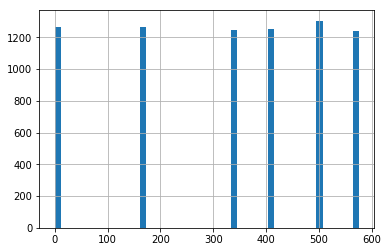

In [25]:
transcript[(transcript['offer_id'] == 'f19421c1d4aa40978ebb69ca19b0e20d') & (transcript['event'] == 'offer received')]['time'].hist(bins = 50)

Observation: An offer is made during any of the offering periods
Observation: Offers may last up to 20 days x 24 hours = 480 hours, so offer periods overlap.
This means that a transaction may be a result of another, older offer, or the person might have been going to make the transaction anyways.


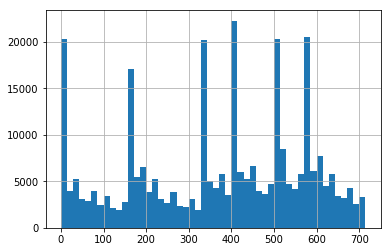

In [26]:
transcript['time'].hist(bins = 50)

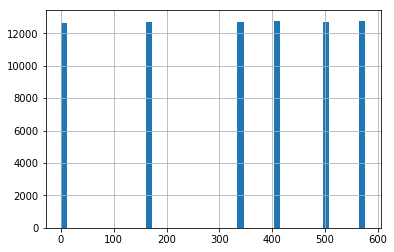

In [27]:
transcript[transcript['event'] == 'offer received']['time'].hist(bins = 50)

In [28]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [29]:
## Who are the customers who responded to BOGO
## Who are the customers who responded to informational
## Who are the custoemrs who responded to discount

discount_ids = list(portfolio[portfolio['offer_type'] == 'discount']['id'])
bogo_ids = list(portfolio[portfolio['offer_type'] == 'bogo']['id'])
informational_ids = list(portfolio[portfolio['offer_type'] == 'informational']['id'])

In [30]:
bogo_ids

['ae264e3637204a6fb9bb56bc8210ddfd',
 '4d5c57ea9a6940dd891ad53e9dbe8da0',
 '9b98b8c7a33c4b65b9aebfe6a799e6d9',
 'f19421c1d4aa40978ebb69ca19b0e20d']

In [31]:
#Build uesr-discount target record

offer_names = {}

offer_names['ae264e3637204a6fb9bb56bc8210ddfd'] = 'bogo_1'
offer_names['4d5c57ea9a6940dd891ad53e9dbe8da0'] = 'bogo_2'
offer_names['3f207df678b143eea3cee63160fa8bed'] = 'info_1'
offer_names['9b98b8c7a33c4b65b9aebfe6a799e6d9'] = 'bogo_3'
offer_names['0b1e1539f2cc45b7b9fa7c272da2e1d7'] = 'discount_1'
offer_names['2298d6c36e964ae4a3e7e9706d1fb8c2'] = 'discount_2'
offer_names['fafdcd668e3743c1bb461111dcafc2a4'] = 'discount_3'
offer_names['5a8bc65990b245e5a138643cd4eb9837'] = 'info_2'
offer_names['f19421c1d4aa40978ebb69ca19b0e20d'] = 'bogo_4'
offer_names['2906b810c7d4411798c6938adc9daaa5'] = 'discount_4'

user_offer_cols = ['person', 'discount_1', 'discount_2', 'discount_3', 'discount_4', 'bogo_1', 'bogo_2', 'bogo_3',
'bogo_4', 'info_1', 'info_2']




In [32]:
## Initialize the user-offer matrix with zeros

df_user_offer = pd.DataFrame(0, index=profile['id'], columns=user_offer_cols)

In [33]:
## Set the user ids from the profiles

df_user_offer['person'] = profile['id']

for i in df_user_offer.index:
    df_user_offer.loc[i, 'person'] = i

df_user_offer

,person,discount_1,discount_2,discount_3,discount_4,bogo_1,bogo_2,bogo_3,bogo_4,info_1,info_2
id,,,,,,,,,,,
68be06ca386d4c31939f3a4f0e3dd783,68be06ca386d4c31939f3a4f0e3dd783,0,0,0,0,0,0,0,0,0,0
0610b486422d4921ae7d2bf64640c50b,0610b486422d4921ae7d2bf64640c50b,0,0,0,0,0,0,0,0,0,0
38fe809add3b4fcf9315a9694bb96ff5,38fe809add3b4fcf9315a9694bb96ff5,0,0,0,0,0,0,0,0,0,0
78afa995795e4d85b5d9ceeca43f5fef,78afa995795e4d85b5d9ceeca43f5fef,0,0,0,0,0,0,0,0,0,0
a03223e636434f42ac4c3df47e8bac43,a03223e636434f42ac4c3df47e8bac43,0,0,0,0,0,0,0,0,0,0
e2127556f4f64592b11af22de27a7932,e2127556f4f64592b11af22de27a7932,0,0,0,0,0,0,0,0,0,0
8ec6ce2a7e7949b1bf142def7d0e0586,8ec6ce2a7e7949b1bf142def7d0e0586,0,0,0,0,0,0,0,0,0,0
68617ca6246f4fbc85e91a2a49552598,68617ca6246f4fbc85e91a2a49552598,0,0,0,0,0,0,0,0,0,0
389bc3fa690240e798340f5a15918d5c,389bc3fa690240e798340f5a15918d5c,0,0,0,0,0,0,0,0,0,0


In [34]:
## Populate the user-offer matrix

def populate_user_offer(row):
    if row['offer_id'] != -1:
        user = str(row['person'])
        offer = str(offer_names[row['offer_id']])        
        df_user_offer.loc[df_user_offer['person'] == user, offer] = 1
        

In [35]:
transcript.apply(populate_user_offer, axis = 1)

0         None
1         None
2         None
3         None
4         None
5         None
6         None
7         None
8         None
9         None
10        None
11        None
12        None
13        None
14        None
15        None
16        None
17        None
18        None
19        None
20        None
21        None
22        None
23        None
24        None
25        None
26        None
27        None
28        None
29        None
          ... 
306504    None
306505    None
306506    None
306507    None
306508    None
306509    None
306510    None
306511    None
306512    None
306513    None
306514    None
306515    None
306516    None
306517    None
306518    None
306519    None
306520    None
306521    None
306522    None
306523    None
306524    None
306525    None
306526    None
306527    None
306528    None
306529    None
306530    None
306531    None
306532    None
306533    None
Length: 306534, dtype: object

In [36]:
df_user_offer

,person,discount_1,discount_2,discount_3,discount_4,bogo_1,bogo_2,bogo_3,bogo_4,info_1,info_2
id,,,,,,,,,,,
68be06ca386d4c31939f3a4f0e3dd783,68be06ca386d4c31939f3a4f0e3dd783,1,1,1,1,0,0,0,0,0,0
0610b486422d4921ae7d2bf64640c50b,0610b486422d4921ae7d2bf64640c50b,0,0,0,0,0,0,1,0,1,0
38fe809add3b4fcf9315a9694bb96ff5,38fe809add3b4fcf9315a9694bb96ff5,0,0,0,0,0,0,1,0,0,1
78afa995795e4d85b5d9ceeca43f5fef,78afa995795e4d85b5d9ceeca43f5fef,0,0,0,0,1,0,1,1,0,1
a03223e636434f42ac4c3df47e8bac43,a03223e636434f42ac4c3df47e8bac43,1,0,0,0,0,0,0,0,1,1
e2127556f4f64592b11af22de27a7932,e2127556f4f64592b11af22de27a7932,0,0,1,1,0,0,1,0,1,0
8ec6ce2a7e7949b1bf142def7d0e0586,8ec6ce2a7e7949b1bf142def7d0e0586,0,0,1,1,0,1,0,0,1,0
68617ca6246f4fbc85e91a2a49552598,68617ca6246f4fbc85e91a2a49552598,0,1,0,1,1,1,1,0,0,0
389bc3fa690240e798340f5a15918d5c,389bc3fa690240e798340f5a15918d5c,0,0,1,1,0,0,1,1,0,0


In [37]:
## TODO:
#For each user:
#Get the offers
#For each offer:
#Get the duration:
#Get that user's transactions over the duration

#For each offer
#Get the duration
#Get all user transactions over the duration

for offer in offer_names:
    col = str(offer_names[offer])
    users_with_offer = list(df_user_offer[df_user_offer[col] == 1]['person'].unique())




# Bayesian Analysis

In [104]:
#Test run for all transactions within the duration of ae264e3637204a6fb9bb56bc8210ddfd
#channels	difficulty	duration	id	offer_type	reward

transactions = []

offer_id = portfolio.loc[0, 'id']
offer_duration_days = portfolio.loc[0, 'duration']
offer_duration_hours = 24 * offer_duration_days

#lookup the users who received the offer and the start time
transcript[transcript['offer_id'] == str(offer_id)]

def get_transacts(row):
    '''
    gets all transactions by the person for the duration hours after the time entry in the row
    '''
    
    #TODO: replace with duration lookup
    duration = offer_duration_hours
    
    start_time = row['time'] - 20
    person = row['person']
    end_time = start_time + duration
    trans_df = transcript[(transcript['person'] == person) & (transcript['time'] <= end_time) & (transcript['time'] >= start_time) & (transcript['amount'] != -1)]
    for index, trans_row in trans_df.iterrows():
        trans_amount = trans_row['amount']
        trans_time = trans_row['time'] - start_time
        transactions.append((trans_time, trans_amount))


In [39]:
demo_df = transcript[transcript['offer_id'] == offer_id].head(50)
demo_df.apply(get_transacts, axis = 1)

12     None
19     None
27     None
35     None
39     None
46     None
52     None
67     None
74     None
75     None
79     None
97     None
104    None
114    None
120    None
128    None
131    None
145    None
157    None
216    None
220    None
221    None
226    None
243    None
255    None
262    None
264    None
265    None
276    None
280    None
299    None
305    None
310    None
313    None
314    None
315    None
321    None
348    None
350    None
367    None
403    None
404    None
405    None
419    None
424    None
426    None
427    None
449    None
466    None
498    None
dtype: object

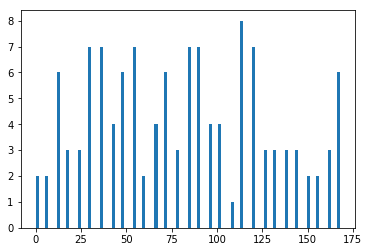

In [40]:
transactions
transaction_times = [i[0] for i in transactions]
plt.hist(transaction_times, bins = 100)

#plt.scatter(*zip(*transactions))
plt.show()

# Bayesian Run-through

In [ ]:
#TODO: do not give tensorflow a time series of the form [0,0,0,x,0,0,0,y,0,0,0 ...]

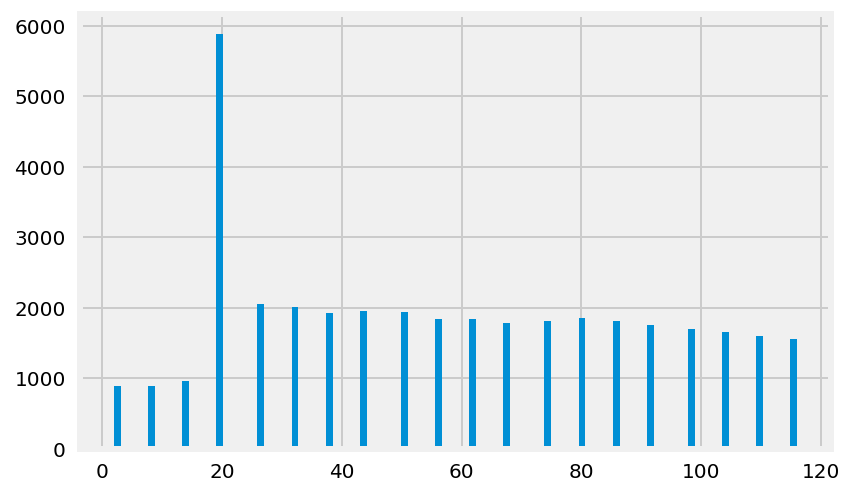

In [214]:
#Test run for all transactions within the duration of ae264e3637204a6fb9bb56bc8210ddfd
#channels	difficulty	duration	id	offer_type	reward

transactions = []

offer_id = portfolio.loc[8, 'id']
offer_duration_days = portfolio.loc[8, 'duration']
offer_duration_hours = 24 * offer_duration_days

#lookup the users who received the offer and the start time
transcript[transcript['offer_id'] == str(offer_id)]

demo_df = transcript[transcript['offer_id'] == offer_id]
demo_df.apply(get_transacts, axis = 1)

transaction_times = [i[0] for i in transactions]
plt.hist(transaction_times, bins = 100)

#plt.scatter(*zip(*transactions))
plt.show()


In [215]:
#transaction history to time series
transcript_series = np.zeros(max(transaction_times) + 1)
for i in transaction_times:
    transcript_series[i] = transcript_series[i] + 1

#strip out zeros
#transcript_series = list(filter(lambda a: a > 0, transcript_series_))
    
transcript_series

array([   0.,    0.,  892.,    0.,    0.,    0.,    0.,    0.,  887.,
          0.,    0.,    0.,    0.,    0.,  958.,    0.,    0.,    0.,
          0.,    0., 5878.,    0.,    0.,    0.,    0.,    0., 2047.,
          0.,    0.,    0.,    0.,    0., 2005.,    0.,    0.,    0.,
          0.,    0., 1927.,    0.,    0.,    0.,    0.,    0., 1951.,
          0.,    0.,    0.,    0.,    0., 1938.,    0.,    0.,    0.,
          0.,    0., 1835.,    0.,    0.,    0.,    0.,    0., 1836.,
          0.,    0.,    0.,    0.,    0., 1787.,    0.,    0.,    0.,
          0.,    0., 1805.,    0.,    0.,    0.,    0.,    0., 1849.,
          0.,    0.,    0.,    0.,    0., 1804.,    0.,    0.,    0.,
          0.,    0., 1752.,    0.,    0.,    0.,    0.,    0., 1694.,
          0.,    0.,    0.,    0.,    0., 1659.,    0.,    0.,    0.,
          0.,    0., 1599.,    0.,    0.,    0.,    0.,    0., 1556.])

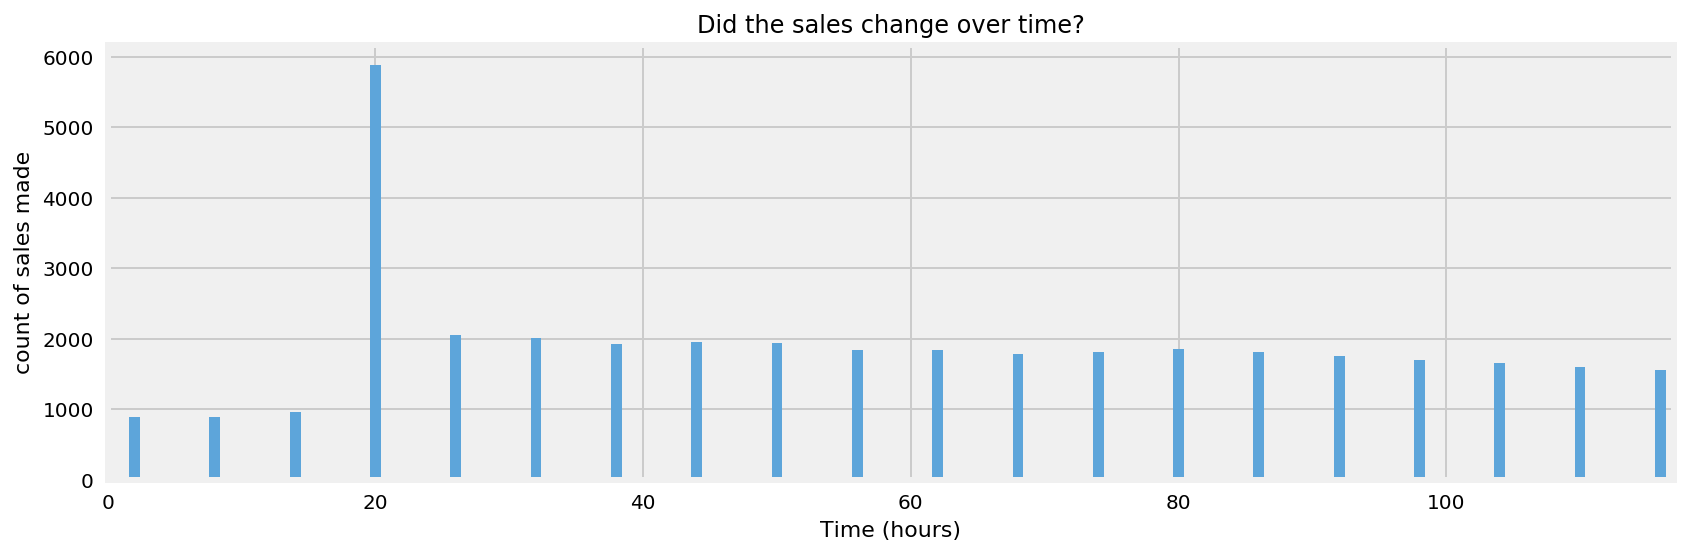

In [216]:
# Defining our Data and assumptions

count_data = tf.constant(transcript_series, dtype=tf.float32)
n_count_data = tf.shape(count_data)
days = tf.range(n_count_data[0])

# Convert from TF to numpy.

[
    count_data_, 
    n_count_data_, 
    days_,
] = evaluate([
    count_data, 
    n_count_data,
    days,
])

# Visualizing the Results
    
plt.figure(figsize=(12.5, 4))
plt.bar(days_, count_data_, color="#5DA5DA")
plt.xlabel("Time (hours)")
plt.ylabel("count of sales made")
plt.title("Did the sales change over time?")
plt.xlim(0, n_count_data_[0]);

In [177]:
def joint_log_prob(count_data, lambda_1, lambda_2, tau):
    tfd = tfp.distributions
 
    alpha = np.array(1. / count_data.mean(), np.float32)
    rv_lambda_1 = tfd.Exponential(rate=alpha)
    rv_lambda_2 = tfd.Exponential(rate=alpha)
 
    rv_tau = tfd.Uniform()
 
    lambda_ = tf.gather(
         [lambda_1, lambda_2],
         indices=tf.to_int32(tau * count_data.size <= np.arange(count_data.size)))
    rv_observation = tfd.Poisson(rate=lambda_)
 
    return (
         rv_lambda_1.log_prob(lambda_1)
         + rv_lambda_2.log_prob(lambda_2)
         + rv_tau.log_prob(tau)
         + tf.reduce_sum(rv_observation.log_prob(count_data))
    )

In [217]:
# Set the chain's start state.
initial_chain_state = [
    tf.to_float(tf.reduce_mean(count_data)) * tf.ones([], dtype=tf.float32, name="init_lambda1"),
    tf.to_float(tf.reduce_mean(count_data)) * tf.ones([], dtype=tf.float32, name="init_lambda2"),
    0.5 * tf.ones([], dtype=tf.float32, name="init_tau"),
]


# Since HMC operates over unconstrained space, we need to transform the
# samples so they live in real-space.
unconstraining_bijectors = [
    tfp.bijectors.Exp(),       # Maps a positive real to R.
    tfp.bijectors.Exp(),       # Maps a positive real to R.
    tfp.bijectors.Sigmoid(),   # Maps [0,1] to R.  
]


def joint_log_prob(count_data, lambda_1, lambda_2, tau):
    tfd = tfp.distributions
 
    alpha = (1. / tf.reduce_mean(count_data))
    rv_lambda_1 = tfd.Exponential(rate=alpha)
    rv_lambda_2 = tfd.Exponential(rate=alpha)
 
    rv_tau = tfd.Uniform()
 

    lambda_ = tf.gather(
         [lambda_1, lambda_2],
         indices=tf.to_int32(tau * tf.to_float(tf.size(count_data)) <= tf.to_float(tf.range(tf.size(count_data)))))
    rv_observation = tfd.Poisson(rate=lambda_)
 
    return (
         rv_lambda_1.log_prob(lambda_1)
         + rv_lambda_2.log_prob(lambda_2)
         + rv_tau.log_prob(tau)
         + tf.reduce_sum(rv_observation.log_prob(count_data))
    )


# Define a closure over our joint_log_prob.
def unnormalized_log_posterior(lambda1, lambda2, tau):
    return joint_log_prob(count_data, lambda1, lambda2, tau)


# Initialize the step_size. (It will be automatically adapted.)
with tf.variable_scope(tf.get_variable_scope(), reuse=True):#reuse=tf.AUTO_REUSE):
    step_size = tf.get_variable(
        name='step_size',
        initializer=tf.constant(0.05, dtype=tf.float32),
        trainable=False,
        use_resource=True
    )
    
tf.get_variable_scope().reuse_variables()

# Sample from the chain.
[
    lambda_1_samples,
    lambda_2_samples,
    posterior_tau,
], kernel_results = tfp.mcmc.sample_chain(
    num_results=100000,
    num_burnin_steps=10000,
    current_state=initial_chain_state,
    kernel=tfp.mcmc.TransformedTransitionKernel(
        inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
            target_log_prob_fn=unnormalized_log_posterior,
            num_leapfrog_steps=2,
            step_size=step_size,
            step_size_update_fn=tfp.mcmc.make_simple_step_size_update_policy(10000), #was ()
            state_gradients_are_stopped=True),
        bijector=unconstraining_bijectors))

tau_samples = tf.floor(posterior_tau * tf.to_float(tf.size(count_data)))

# tau_samples, lambda_1_samples, lambda_2_samples contain
# N samples from the corresponding posterior distribution
N = tf.shape(tau_samples)[0]
expected_texts_per_day = tf.zeros(n_count_data)


# Initialize any created variables.
init_g = tf.global_variables_initializer()
init_l = tf.local_variables_initializer()

In [218]:
evaluate(init_g)
evaluate(init_l)
[
    lambda_1_samples_,
    lambda_2_samples_,
    tau_samples_,
    kernel_results_,
    N_,
    expected_texts_per_day_,
] = evaluate([
    lambda_1_samples,
    lambda_2_samples,
    tau_samples,
    kernel_results,
    N,
    expected_texts_per_day,
])

    
print("acceptance rate: {}".format(
    kernel_results_.inner_results.is_accepted.mean()))
print("final step size: {}".format(
    kernel_results_.inner_results.extra.step_size_assign[-100:].mean()))


acceptance rate: 0.54056
final step size: 0.008339169435203075


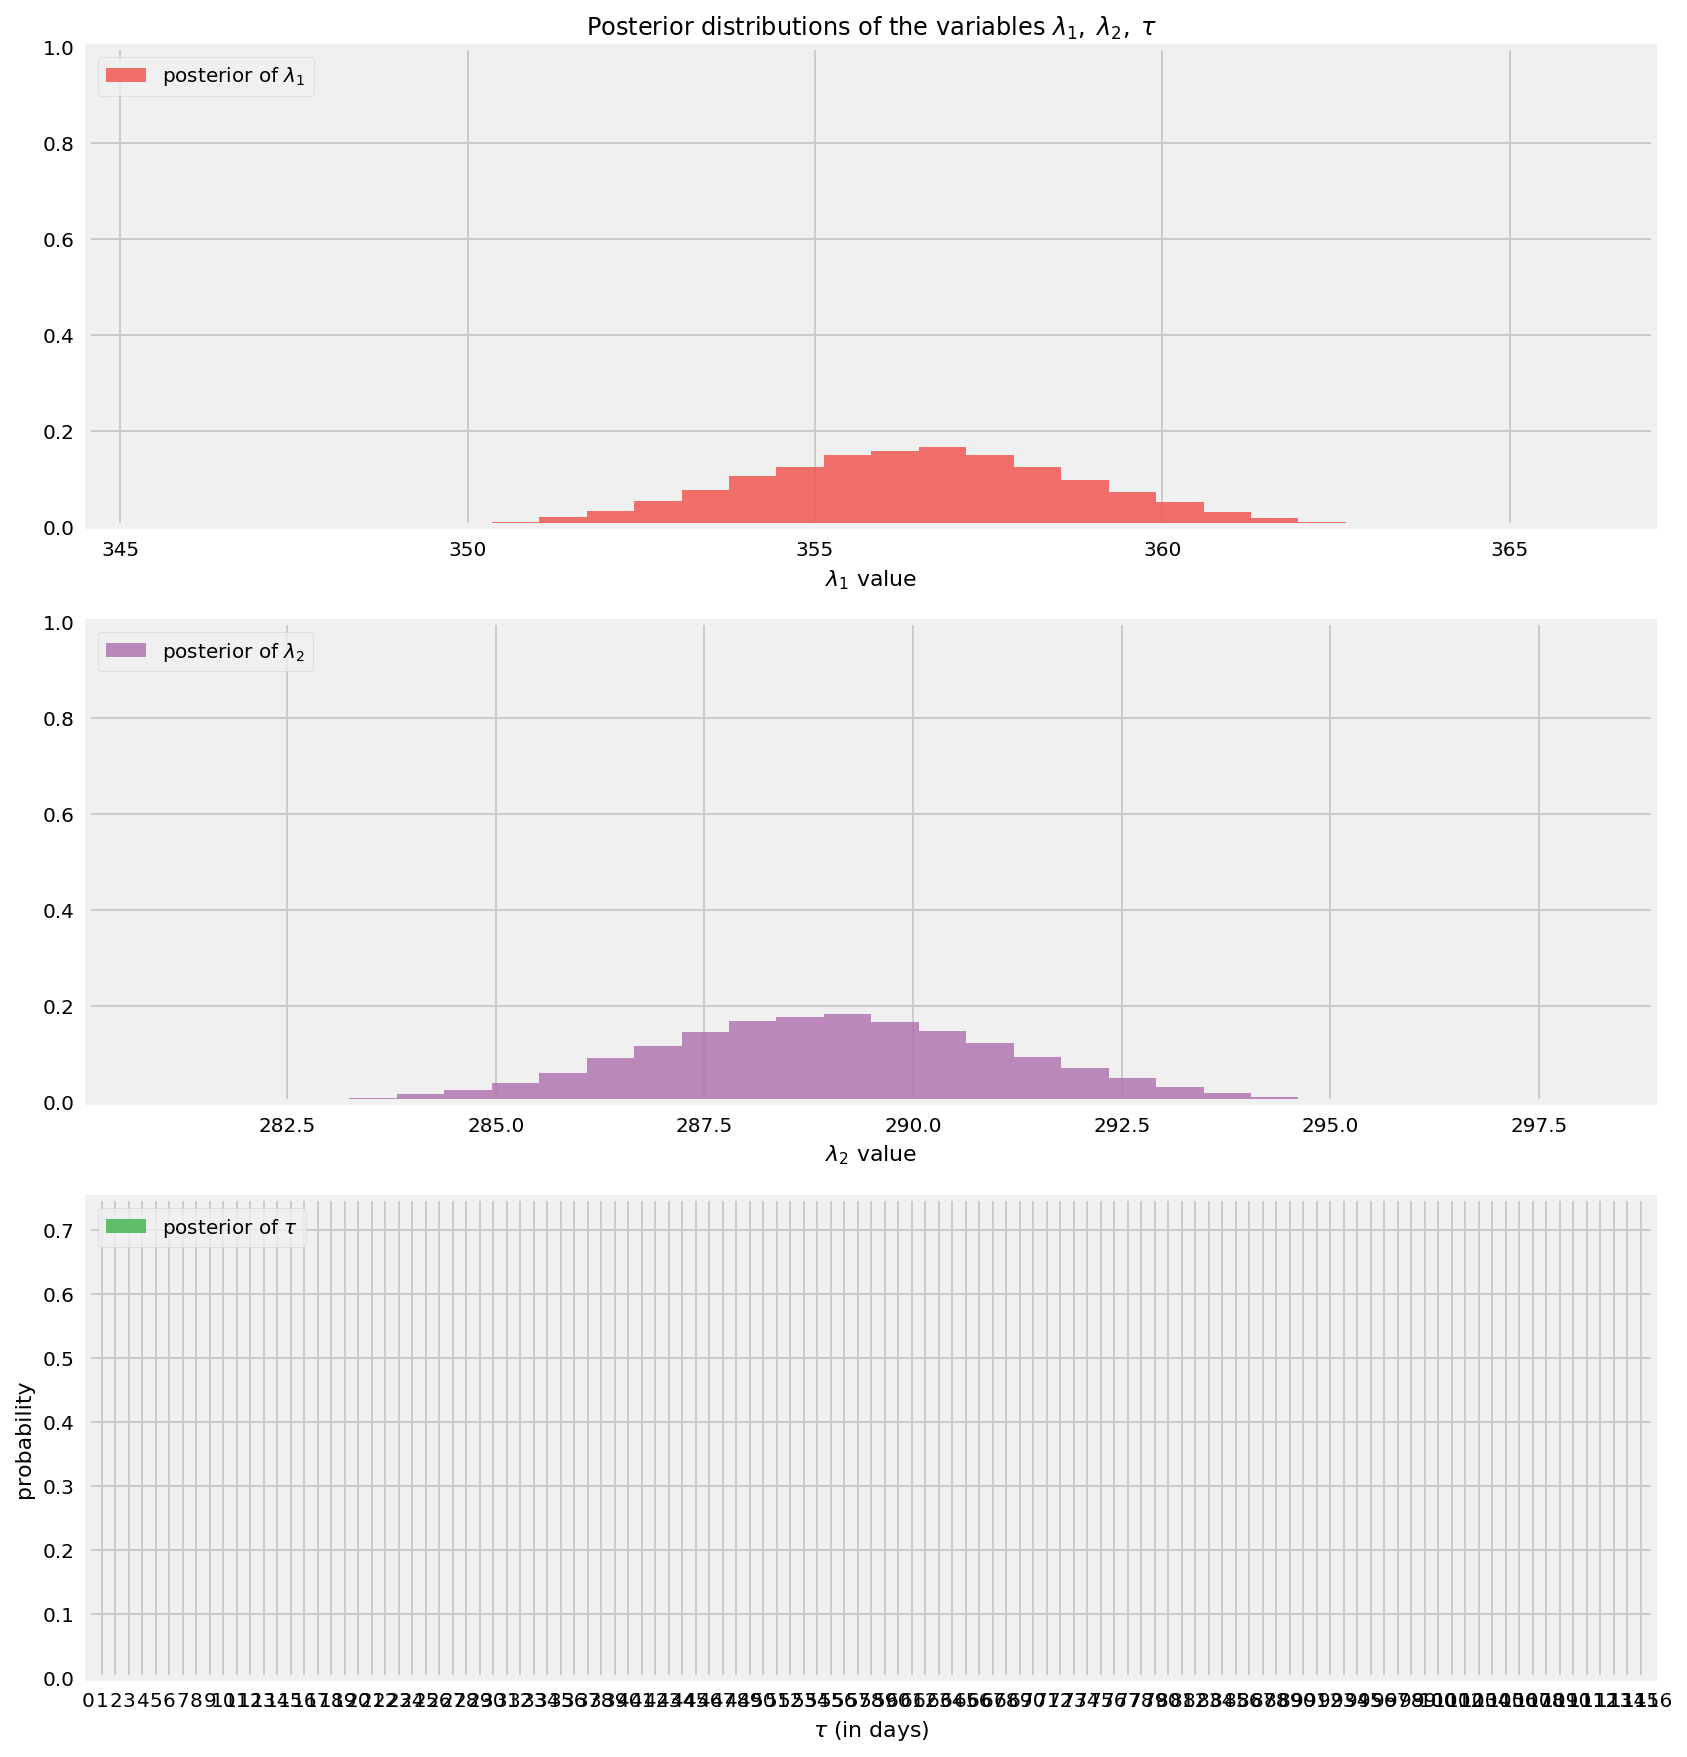

In [219]:
plt.figure(figsize=(12.5, 15))
#histogram of the samples:

ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples_, histtype='stepfilled', bins=30, alpha=0.85,
         label=r"posterior of $\lambda_1$", color=TFColor[0], density=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables $\lambda_1,\;\lambda_2,\;\tau$""")
#plt.xlim([0, 50])
plt.xlabel(r"$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples_, histtype='stepfilled', bins=30, alpha=0.85,
         label=r"posterior of $\lambda_2$", color=TFColor[6], density=True)
plt.legend(loc="upper left")
#plt.xlim([0, 50])
plt.xlabel(r"$\lambda_2$ value")

plt.subplot(313)
w = 1.0 / tau_samples_.shape[0] * np.ones_like(tau_samples_)
plt.hist(tau_samples_, bins=n_count_data_[0], alpha=1,
         label=r"posterior of $\tau$",
         color=TFColor[2], weights=w, rwidth=2.)
plt.xticks(np.arange(n_count_data_[0]))

plt.legend(loc="upper left")
plt.ylim([0, .75])
#plt.xlim([0, len(count_data_)-20])
plt.xlabel(r"$\tau$ (in days)")
plt.ylabel(r"probability");

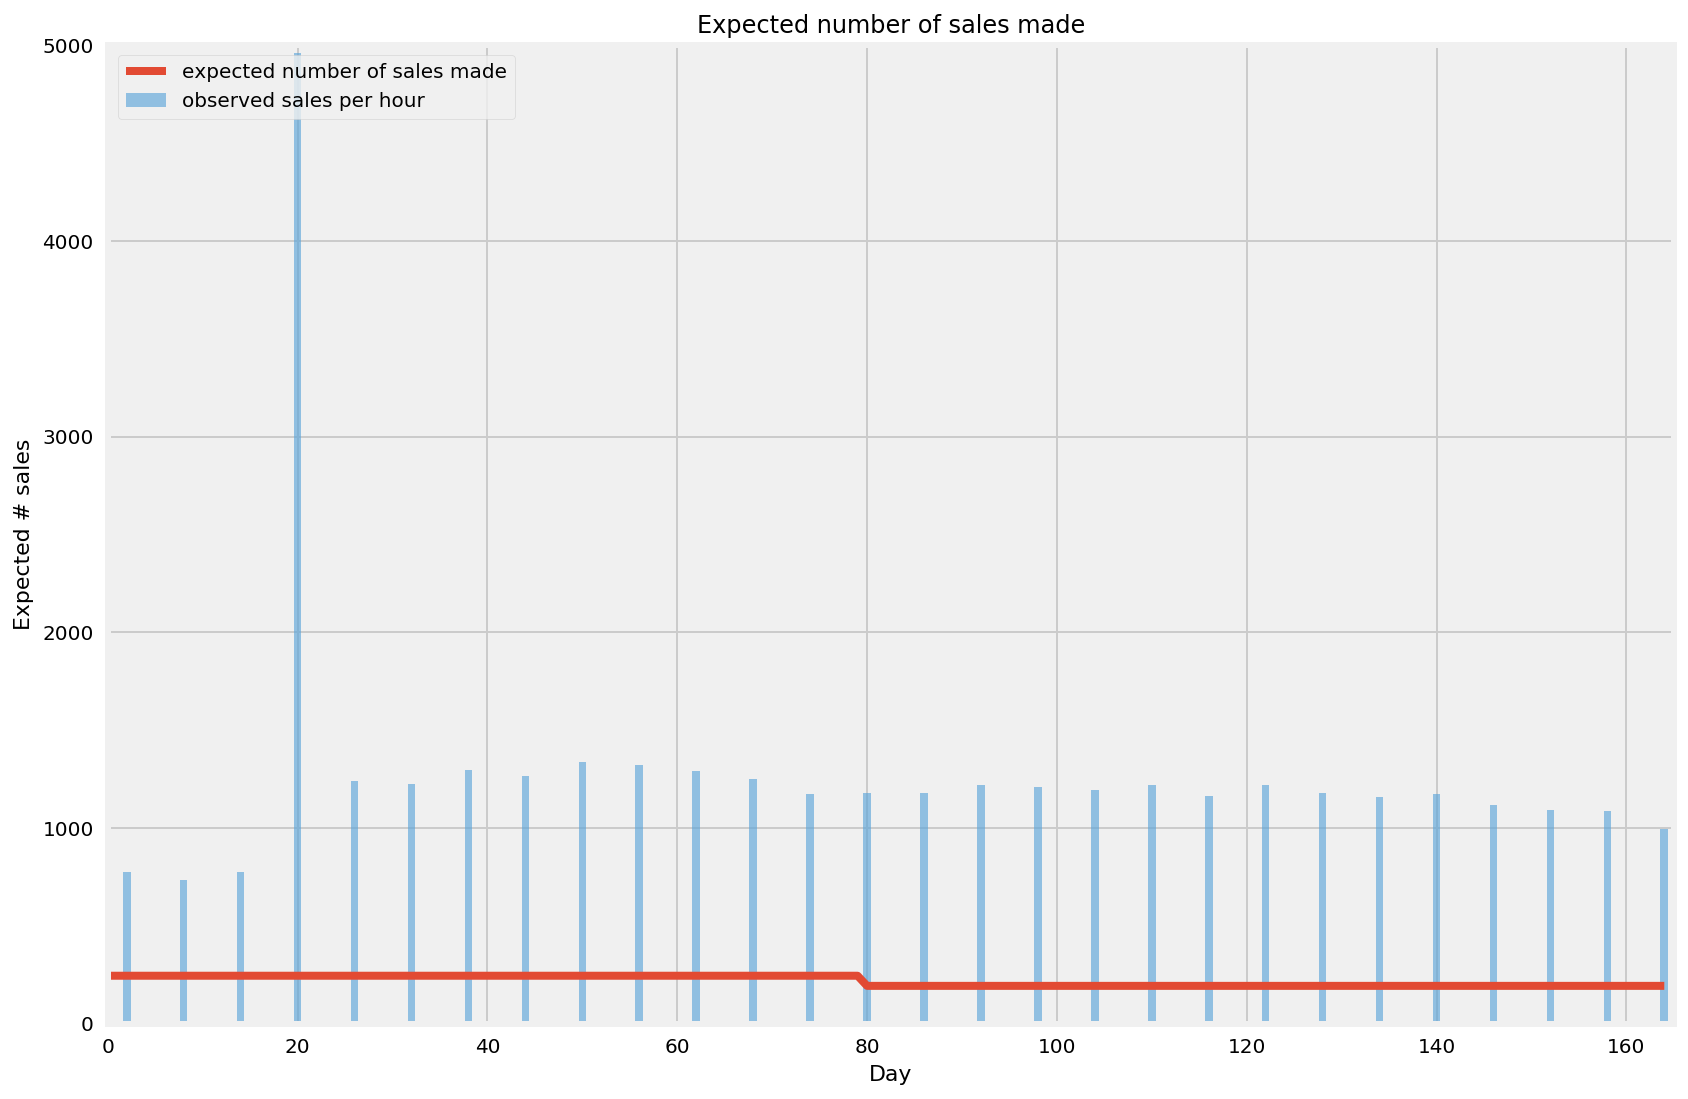

In [213]:
plt.figure(figsize=(12.5, 9))

for day in range(0, n_count_data_[0]):
    # ix is a bool index of all tau samples corresponding to
    # the switchpoint occurring prior to value of 'day'
    ix = day < tau_samples_
    # Each posterior sample corresponds to a value for tau.
    # for each day, that value of tau indicates whether we're "before"
    # (in the lambda1 "regime") or
    #  "after" (in the lambda2 "regime") the switchpoint.
    # by taking the posterior sample of lambda1/2 accordingly, we can average
    # over all samples to get an expected value for lambda on that day.
    # As explained, the "message count" random variable is Poisson distributed,
    # and therefore lambda (the poisson parameter) is the expected value of
    # "message count".
    expected_texts_per_day_[day] = (lambda_1_samples_[ix].sum()
                                   + lambda_2_samples_[~ix].sum()) / N_


plt.plot(range(n_count_data_[0]), expected_texts_per_day_, lw=4, color="#E24A33",
         label="expected number of sales made")
plt.xlim(0, n_count_data_[0])
plt.xlabel("Day")
plt.ylabel("Expected # sales")
plt.title("Expected number of sales made")
plt.ylim(0, 5000)
plt.bar(np.arange(len(count_data_)), count_data_, color="#5DA5DA", alpha=0.65,
        label="observed sales per hour")

plt.legend(loc="upper left");

In [220]:
'''
EXAMPLE INITIALIZATION
transactions = []

offer_id = portfolio.loc[8, 'id']
offer_duration_days = portfolio.loc[8, 'duration']
offer_duration_hours = 24 * offer_duration_days

#lookup the users who received the offer and the start time
transcript[transcript['offer_id'] == str(offer_id)]

demo_df = transcript[transcript['offer_id'] == offer_id]
demo_df.apply(get_transacts, axis = 1)

transaction_times = [i[0] for i in transactions]
plt.hist(transaction_times, bins = 100)

plt.show()

'''

def evaluate_bayesian(transaction_times):
    #transaction history to time series
    transcript_series = np.zeros(max(transaction_times) + 1)
    for i in transaction_times:
        transcript_series[i] = transcript_series[i] + 1


        #Set up the markov chain
        # Set the chain's start state.
    initial_chain_state = [
        tf.to_float(tf.reduce_mean(count_data)) * tf.ones([], dtype=tf.float32, name="init_lambda1"),
        tf.to_float(tf.reduce_mean(count_data)) * tf.ones([], dtype=tf.float32, name="init_lambda2"),
        0.5 * tf.ones([], dtype=tf.float32, name="init_tau"),
    ]


    # Since HMC operates over unconstrained space, we need to transform the
    # samples so they live in real-space.
    unconstraining_bijectors = [
        tfp.bijectors.Exp(),       # Maps a positive real to R.
        tfp.bijectors.Exp(),       # Maps a positive real to R.
        tfp.bijectors.Sigmoid(),   # Maps [0,1] to R.  
    ]                                                             


    # Initialize the step_size. (It will be automatically adapted.)
    with tf.variable_scope(tf.get_variable_scope(), reuse=True):#reuse=tf.AUTO_REUSE):
        step_size = tf.get_variable(
            name='step_size',
            initializer=tf.constant(0.05, dtype=tf.float32),
            trainable=False,
            use_resource=True
        )

    tf.get_variable_scope().reuse_variables()

    # Sample from the chain.
    [
        lambda_1_samples,
        lambda_2_samples,
        posterior_tau,
    ], kernel_results = tfp.mcmc.sample_chain(
        num_results=100000,
        num_burnin_steps=10000,
        current_state=initial_chain_state,
        kernel=tfp.mcmc.TransformedTransitionKernel(
            inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
                target_log_prob_fn=unnormalized_log_posterior,
                num_leapfrog_steps=2,
                step_size=step_size,
                step_size_update_fn=tfp.mcmc.make_simple_step_size_update_policy(10000), #was ()
                state_gradients_are_stopped=True),
            bijector=unconstraining_bijectors))

    tau_samples = tf.floor(posterior_tau * tf.to_float(tf.size(count_data)))

    # tau_samples, lambda_1_samples, lambda_2_samples contain
    # N samples from the corresponding posterior distribution
    N = tf.shape(tau_samples)[0]
    expected_texts_per_day = tf.zeros(n_count_data)


    # Initialize any created variables.
    init_g = tf.global_variables_initializer()
    init_l = tf.local_variables_initializer()
    
    evaluate(init_g)
    evaluate(init_l)
    [
        lambda_1_samples_,
        lambda_2_samples_,
        tau_samples_,
        kernel_results_,
        N_,
        expected_texts_per_day_,
    ] = evaluate([
        lambda_1_samples,
        lambda_2_samples,
        tau_samples,
        kernel_results,
        N,
        expected_texts_per_day,
    ])


    print("acceptance rate: {}".format(
        kernel_results_.inner_results.is_accepted.mean()))
    print("final step size: {}".format(
        kernel_results_.inner_results.extra.step_size_assign[-100:].mean()))
    
    plt.figure(figsize=(12.5, 15))
    #histogram of the samples:

    ax = plt.subplot(311)
    ax.set_autoscaley_on(False)

    plt.hist(lambda_1_samples_, histtype='stepfilled', bins=30, alpha=0.85,
             label=r"posterior of $\lambda_1$", color=TFColor[0], density=True)
    plt.legend(loc="upper left")
    plt.title(r"""Posterior distributions of the variables $\lambda_1,\;\lambda_2,\;\tau$""")
    #plt.xlim([0, 50])
    plt.xlabel(r"$\lambda_1$ value")

    ax = plt.subplot(312)
    ax.set_autoscaley_on(False)
    plt.hist(lambda_2_samples_, histtype='stepfilled', bins=30, alpha=0.85,
             label=r"posterior of $\lambda_2$", color=TFColor[6], density=True)
    plt.legend(loc="upper left")
    #plt.xlim([0, 50])
    plt.xlabel(r"$\lambda_2$ value")

    plt.subplot(313)
    w = 1.0 / tau_samples_.shape[0] * np.ones_like(tau_samples_)
    plt.hist(tau_samples_, bins=n_count_data_[0], alpha=1,
             label=r"posterior of $\tau$",
             color=TFColor[2], weights=w, rwidth=2.)
    plt.xticks(np.arange(n_count_data_[0]))

    plt.legend(loc="upper left")
    plt.ylim([0, .75])
    #plt.xlim([0, len(count_data_)-20])
    plt.xlabel(r"$\tau$ (in days)")
    plt.ylabel(r"probability");
    
    plt.figure(figsize=(12.5, 9))

    for day in range(0, n_count_data_[0]):
        # ix is a bool index of all tau samples corresponding to
        # the switchpoint occurring prior to value of 'day'
        ix = day < tau_samples_
        # Each posterior sample corresponds to a value for tau.
        # for each day, that value of tau indicates whether we're "before"
        # (in the lambda1 "regime") or
        #  "after" (in the lambda2 "regime") the switchpoint.
        # by taking the posterior sample of lambda1/2 accordingly, we can average
        # over all samples to get an expected value for lambda on that day.
        # As explained, the "message count" random variable is Poisson distributed,
        # and therefore lambda (the poisson parameter) is the expected value of
        # "message count".
        expected_texts_per_day_[day] = (lambda_1_samples_[ix].sum()
                                       + lambda_2_samples_[~ix].sum()) / N_


    plt.plot(range(n_count_data_[0]), expected_texts_per_day_, lw=4, color="#E24A33",
             label="expected number of sales made")
    plt.xlim(0, n_count_data_[0])
    plt.xlabel("Day")
    plt.ylabel("Expected # sales")
    plt.title("Expected number of sales made")
    plt.ylim(0, 5000)
    plt.bar(np.arange(len(count_data_)), count_data_, color="#5DA5DA", alpha=0.65,
            label="observed sales per hour")

    plt.legend(loc="upper left");


acceptance rate: 0.51865
final step size: 0.010175369679927826


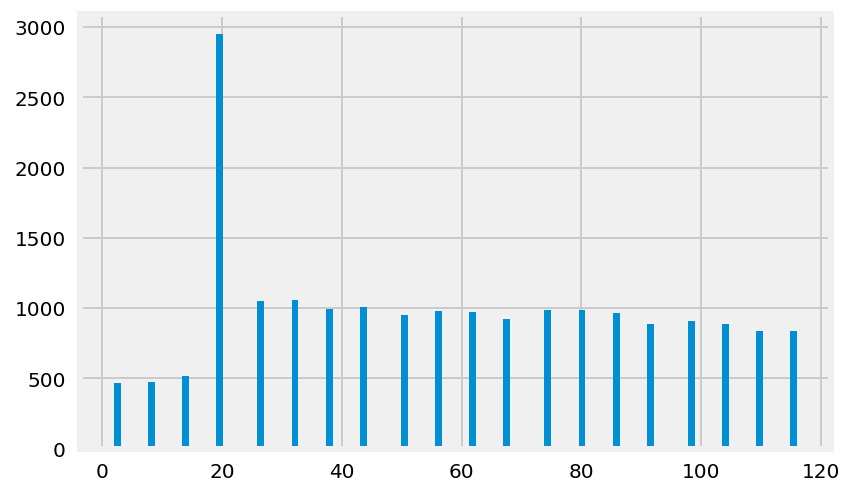

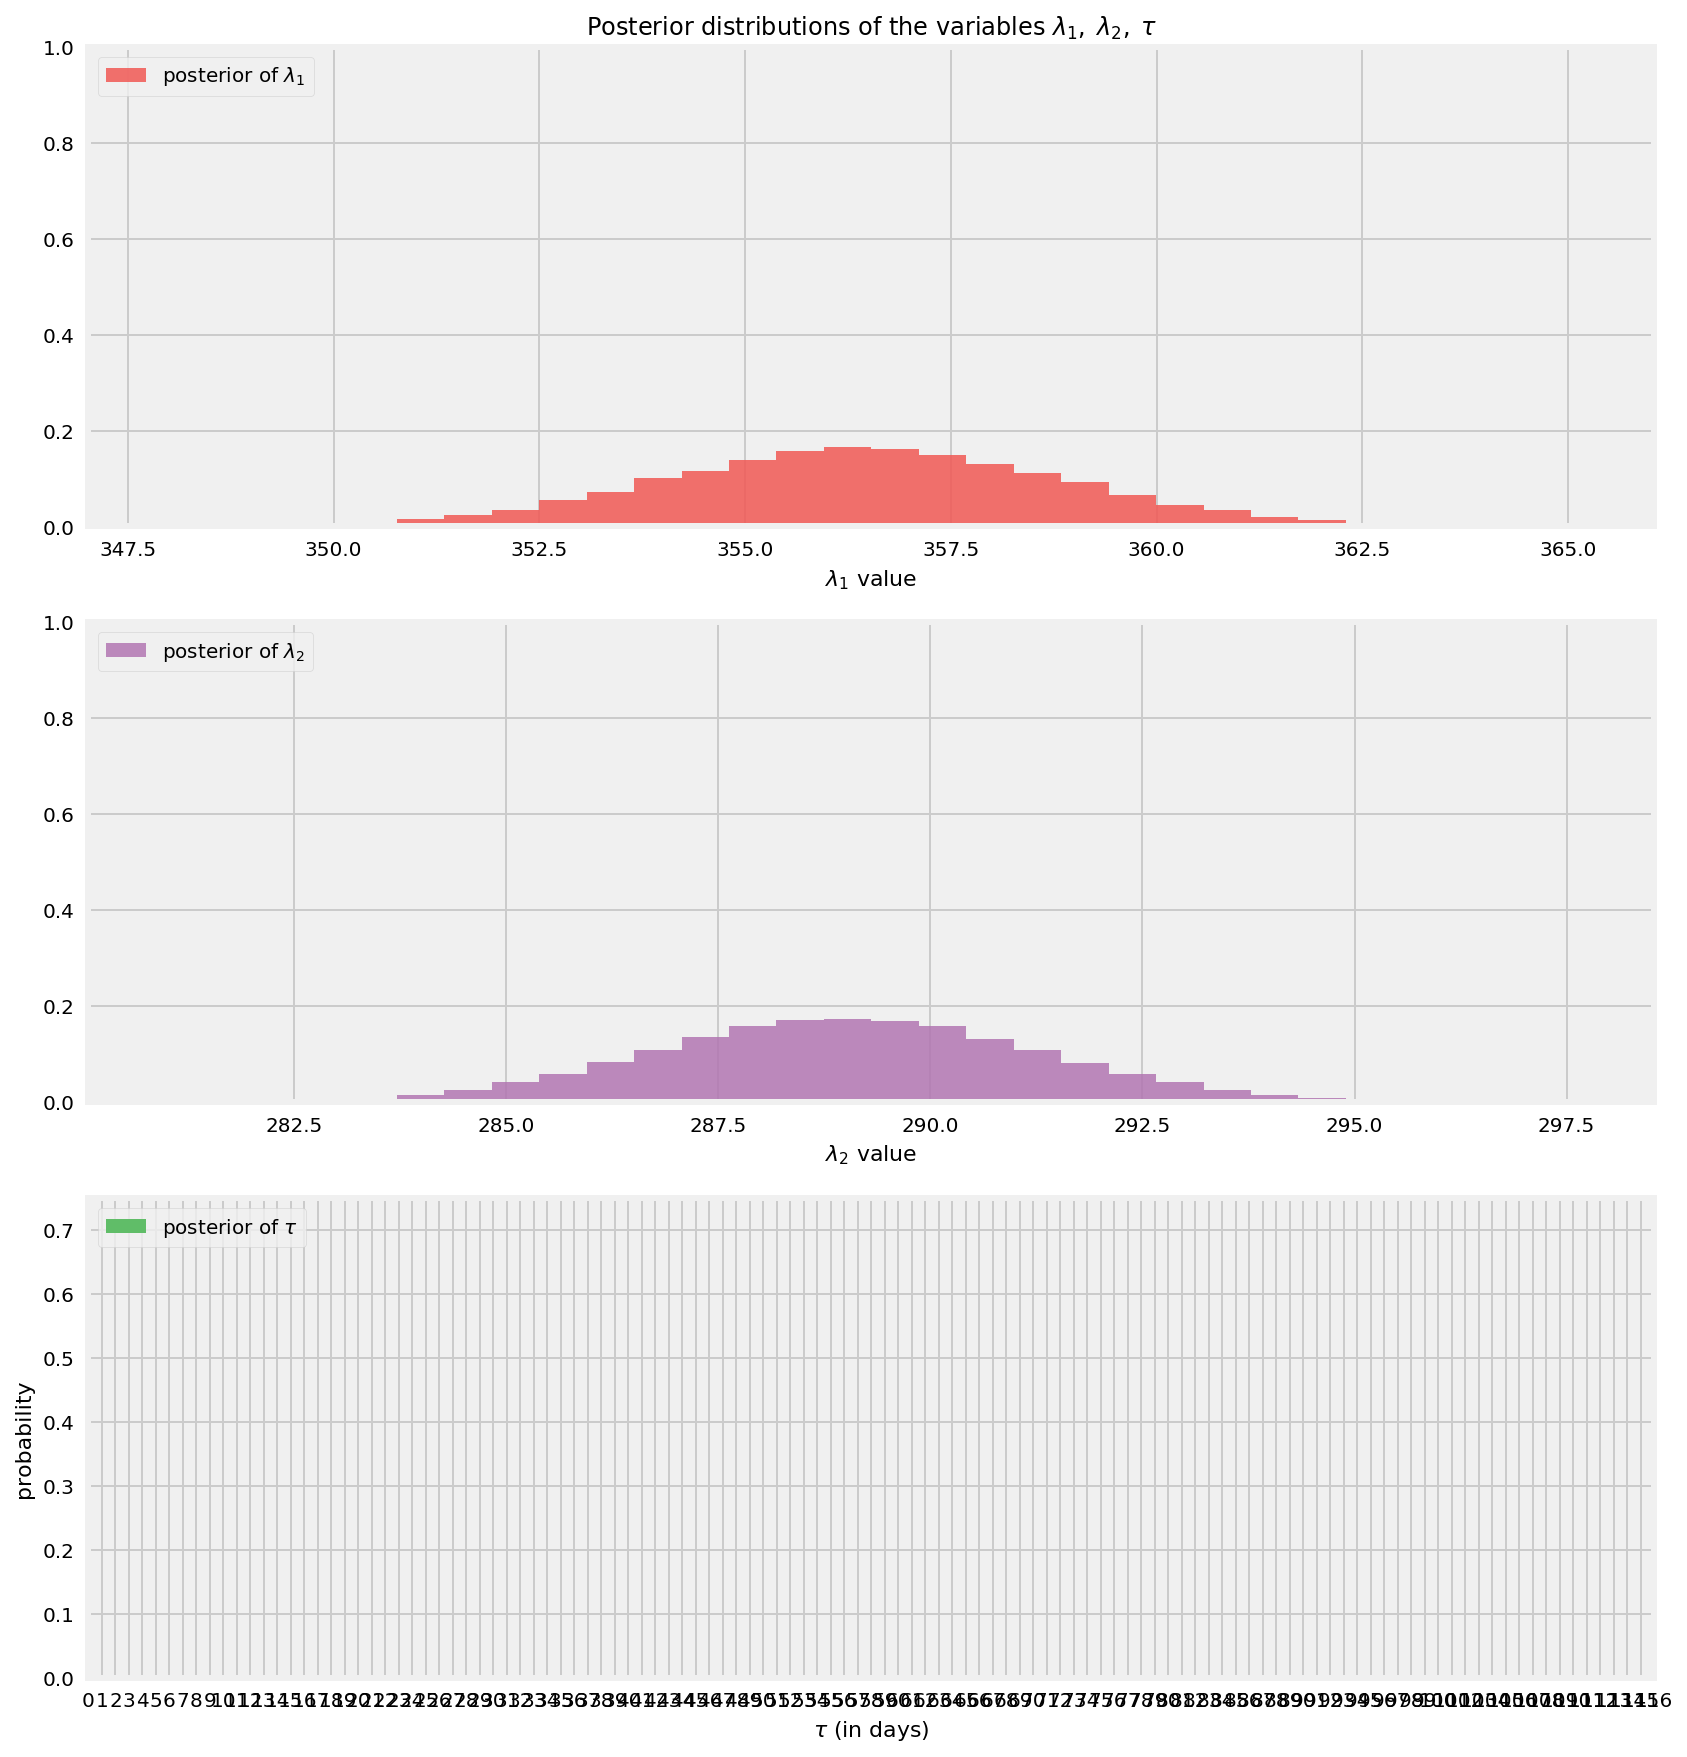

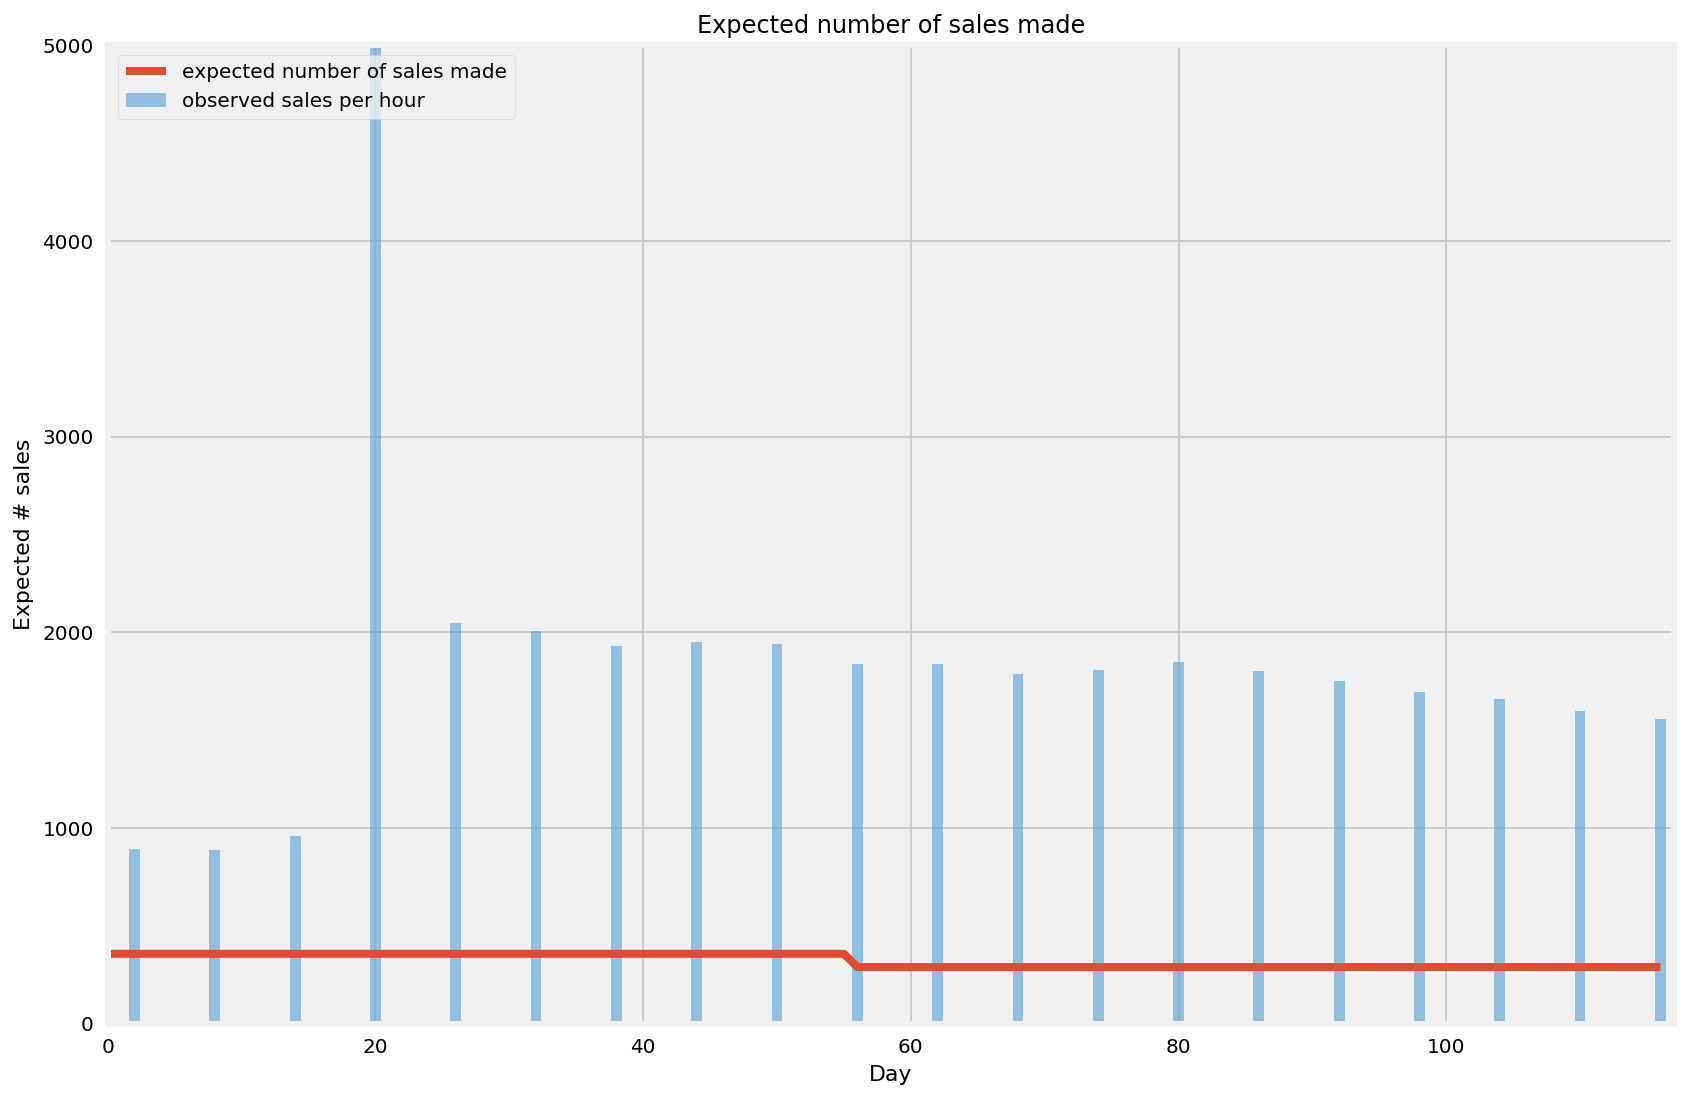

In [226]:
transactions = []

user_query = list(profile[profile['gender'] == 'M']['id'])

offer_id = portfolio.loc[8, 'id']
offer_duration_days = portfolio.loc[8, 'duration']
offer_duration_hours = 24 * offer_duration_days

#lookup the users who received the offer and the start time
#transcript[(transcript['offer_id'] == str(offer_id)) & (transcript['person'] in user_query) ]

demo_df = transcript.query('offer_id == @offer_id & person in @user_query')
demo_df.apply(get_transacts, axis = 1)

transaction_times = [i[0] for i in transactions]
plt.hist(transaction_times, bins = 100)

evaluate_bayesian(transaction_times)